In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators.consistency import ConsistencyValidator

%matplotlib inline

## 1. Load Data
Load the portfolio data from the CSV file.

In [3]:
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions.")

Loaded 7721 positions.


## 2. Run Consistency Validator
We run the validator to check for discrepancies between **Trade Price** and **Market Price** (`Price`).

In [4]:
validator = ConsistencyValidator(positions, trades)
errors = validator.validate()

print(f"Found {len(errors)} consistency errors.")

if errors:
    # Convert to DataFrame for easier analysis
    error_df = pd.DataFrame([vars(e) for e in errors])
    
    # Show distribution of severity
    print("Severity Distribution:")
    print(error_df['severity'].value_counts())
    
    display(error_df.head(10))
else:
    print("No consistency errors found.")

Found 27 consistency errors.
Severity Distribution:
severity
Low       23
High       2
Medium     2
Name: count, dtype: int64


,date,ticker,error_type,description,severity
0,2022-02-07,RIVN,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 62.79 vs Market Pr...,Low
1,2022-02-28,DQ,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 44.90 vs Market Pr...,Low
2,2022-03-09,KAP,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 32.84 vs Market Pr...,High
3,2022-03-11,BNTX,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 144.75 vs Market P...,Low
4,2022-03-16,BNTX,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 152.09 vs Market P...,Low
5,2022-03-16,MRNA,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 154.16 vs Market P...,Medium
6,2022-03-30,MRNA,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 185.55 vs Market P...,Low
7,2022-04-21,ARKK,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 56.43 vs Market Pr...,Low
8,2022-04-21,GME,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 152.89 vs Market P...,Low
9,2022-05-11,ARKK,Consistency Error (Trade vs Market),Price Mismatch: Trade Price 39.75 vs Market Pr...,Low


## 3. Visualization: Trade Price vs Market Price
We visualize the relationship between the executed Trade Price and the reported Market Price.
*   **X-Axis**: Market Price
*   **Y-Axis**: Trade Price

Points significantly off the diagonal line indicate potential data quality issues.

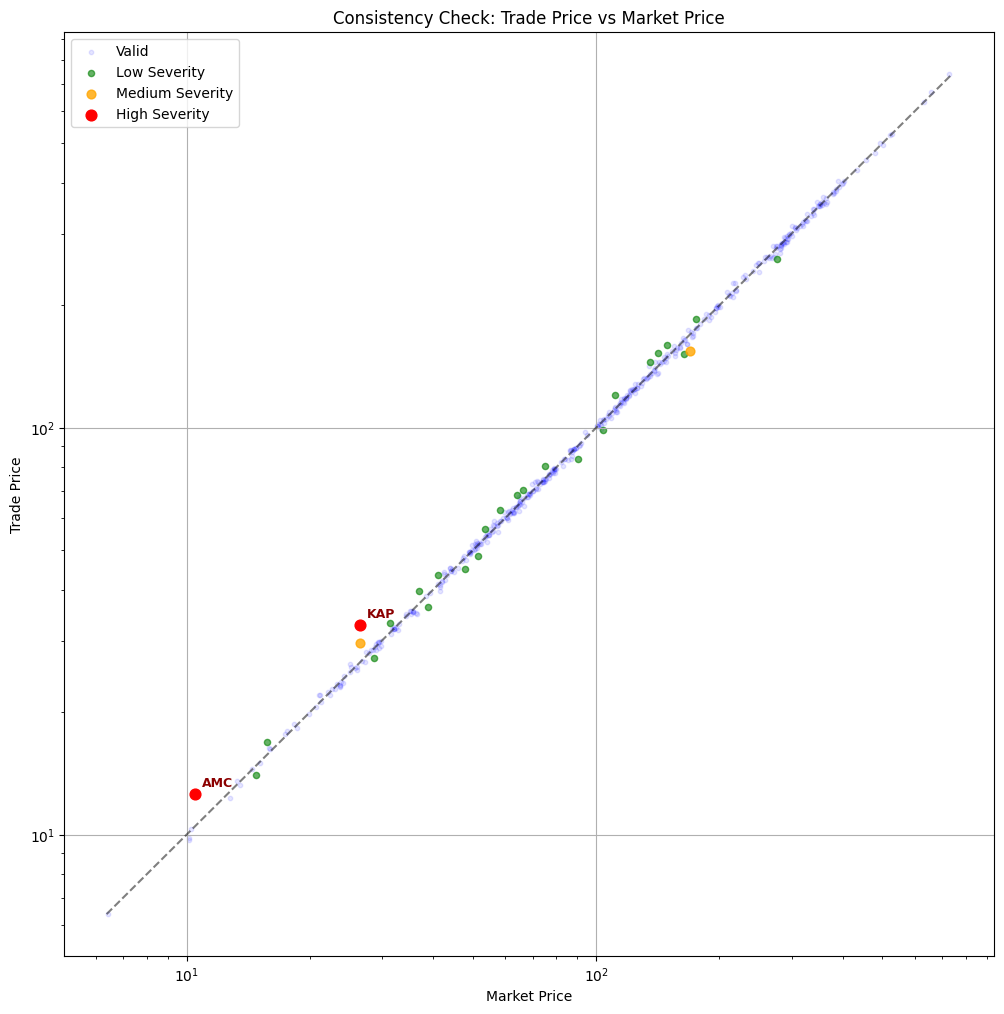

In [5]:
if errors:
    # Prepare data for plotting
    # We need to join errors back to the original data or just use the error details if we had them all.
    # But the validator only returns errors. Let's reconstruct the view from positions df.
    
    df = positions.copy()
    cols = ["Price", "Trade Price", "Traded Today"]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Filter for days with trades
    df = df[df["Traded Today"].abs() > 0].copy()
    df = df.dropna(subset=["Price", "Trade Price"])
    
    # Identify error rows
    error_keys = set((e.date, e.ticker) for e in errors)
    severity_map = {(e.date, e.ticker): e.severity for e in errors}
    
    df['Is_Error'] = df.apply(lambda row: (row['Date'], row['P_Ticker']) in error_keys, axis=1)
    df['Severity'] = df.apply(lambda row: severity_map.get((row['Date'], row['P_Ticker']), 'None'), axis=1)
    
    plt.figure(figsize=(12, 12))
    
    # 1. Plot "Valid" points
    valid_data = df[~df['Is_Error']]
    plt.scatter(valid_data["Price"], valid_data["Trade Price"], 
                alpha=0.1, c='blue', label='Valid', s=10)
    
    # 2. Plot Errors by Severity
    high = df[df['Severity'] == 'High']
    med = df[df['Severity'] == 'Medium']
    low = df[df['Severity'] == 'Low']
    
    if not low.empty:
        plt.scatter(low["Price"], low["Trade Price"], c='green', label='Low Severity', s=20, alpha=0.6)
    if not med.empty:
        plt.scatter(med["Price"], med["Trade Price"], c='orange', label='Medium Severity', s=40, alpha=0.8)
    if not high.empty:
        plt.scatter(high["Price"], high["Trade Price"], c='red', label='High Severity', s=60, alpha=1.0)
    
    # Annotate High Severity Errors
    annotated_tickers = set()
    for idx, row in high.iterrows():
        if row['P_Ticker'] not in annotated_tickers:
            plt.annotate(f"{row['P_Ticker']}", 
                         (row['Price'], row['Trade Price']),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=9, color='darkred', fontweight='bold')
            annotated_tickers.add(row['P_Ticker'])
            if len(annotated_tickers) >= 10: break

    # Diagonal line
    max_val = max(df["Price"].max(), df["Trade Price"].max())
    min_val = min(df["Price"].min(), df["Trade Price"].min())
    
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    plt.title("Consistency Check: Trade Price vs Market Price")
    plt.xlabel("Market Price")
    plt.ylabel("Trade Price")
    plt.legend()
    plt.grid(True)
    
    # Use log scale if range is huge
    if max_val / (min_val + 0.01) > 100:
        plt.xscale('log')
        plt.yscale('log')
    
    plt.show()
else:
    print("No errors to visualize.")

## 4. Time Series Analysis: High Severity Errors
For tickers with high severity errors, we plot the Market Price and Trade Price over time to see if the discrepancy is persistent.

Visualizing 19 tickers with consistency errors.
Visualizing consistency errors for: RHM (Count: 1)


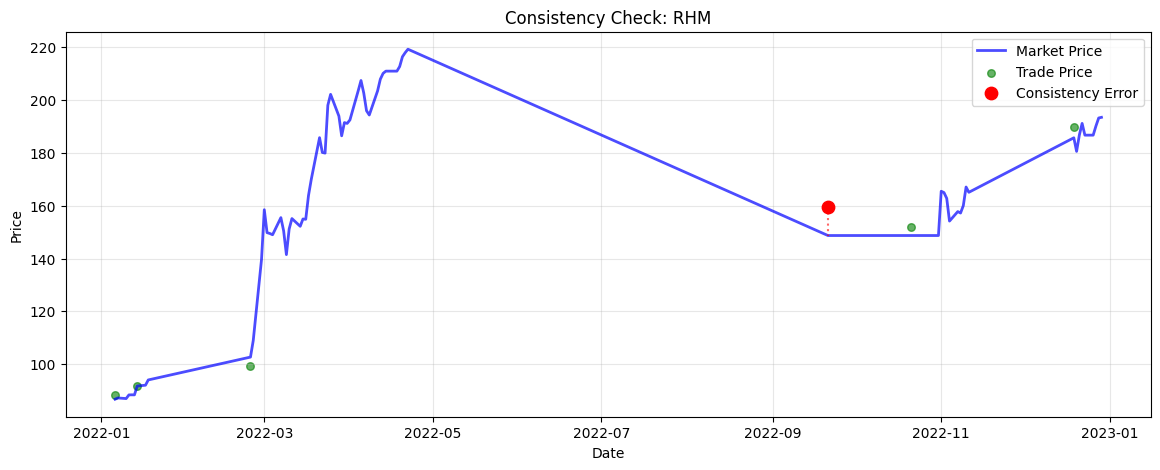

Visualizing consistency errors for: NDA1 (Count: 1)


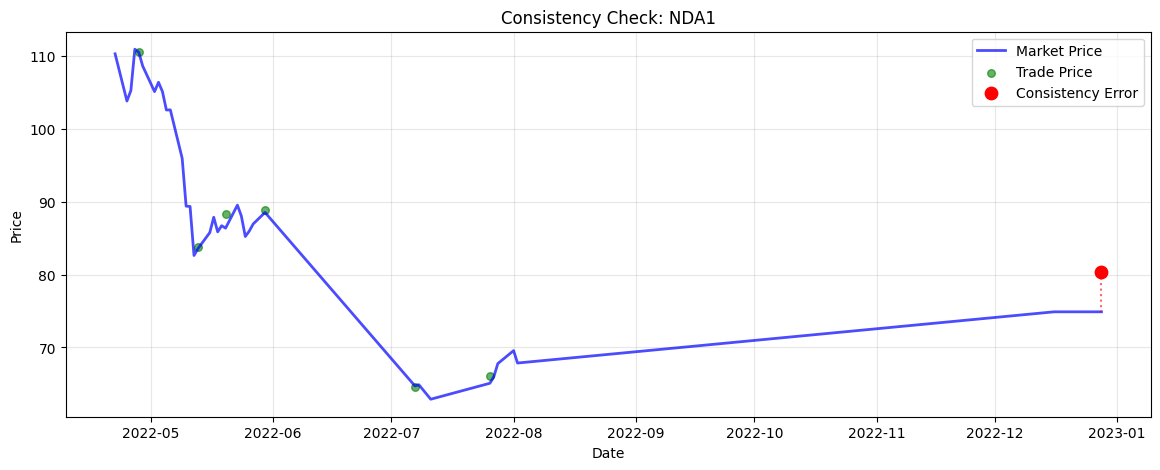

Visualizing consistency errors for: MRNA (Count: 2)


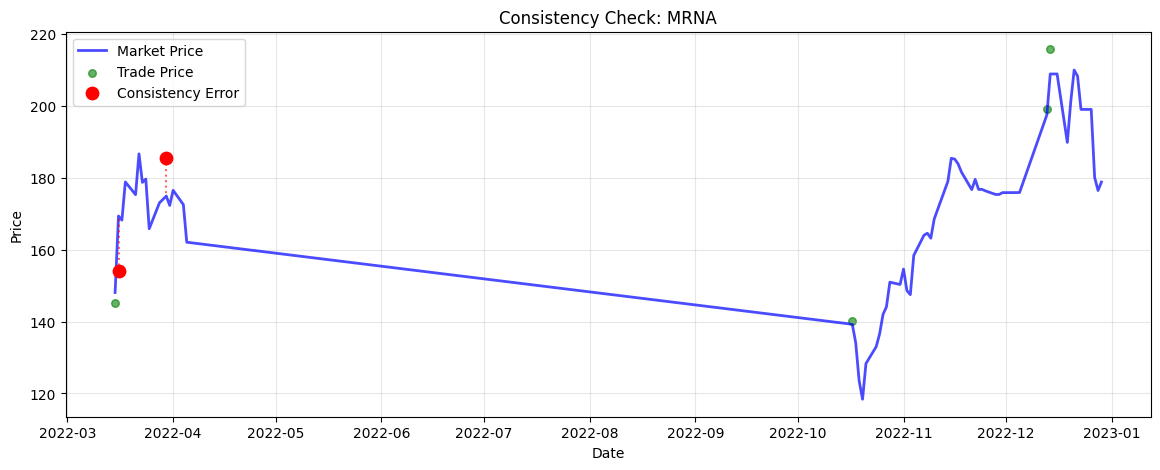

Visualizing consistency errors for: EXS1 (Count: 1)


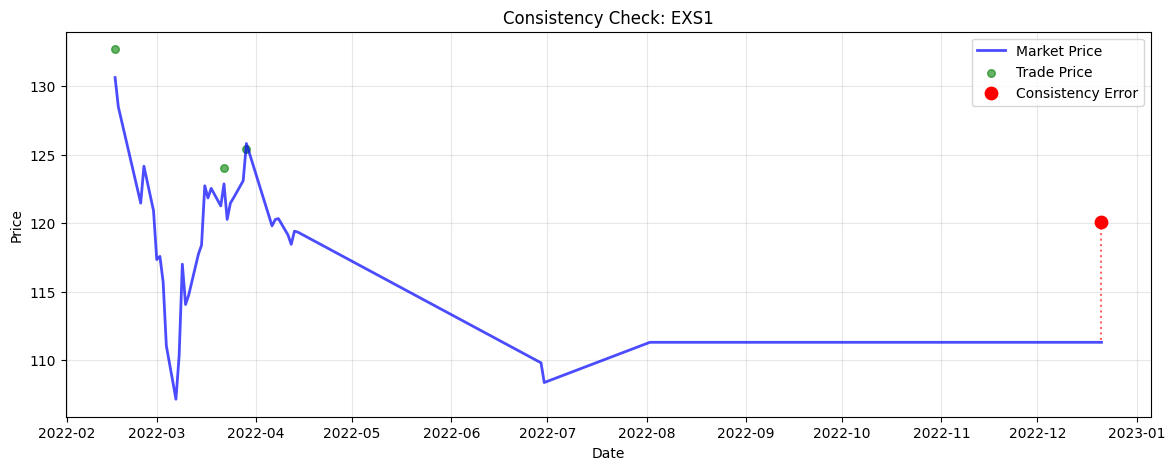

Visualizing consistency errors for: DQ (Count: 3)


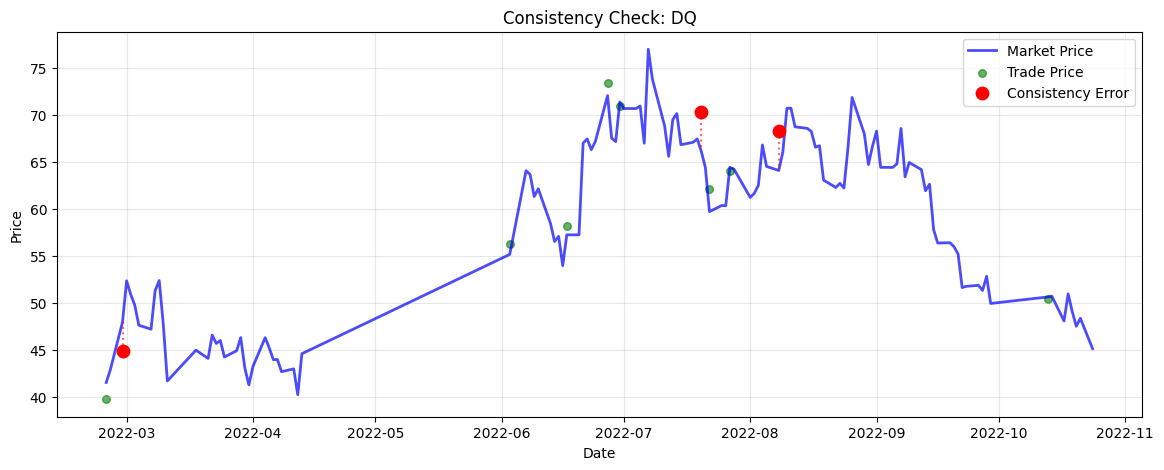

Visualizing consistency errors for: VIXY (Count: 1)


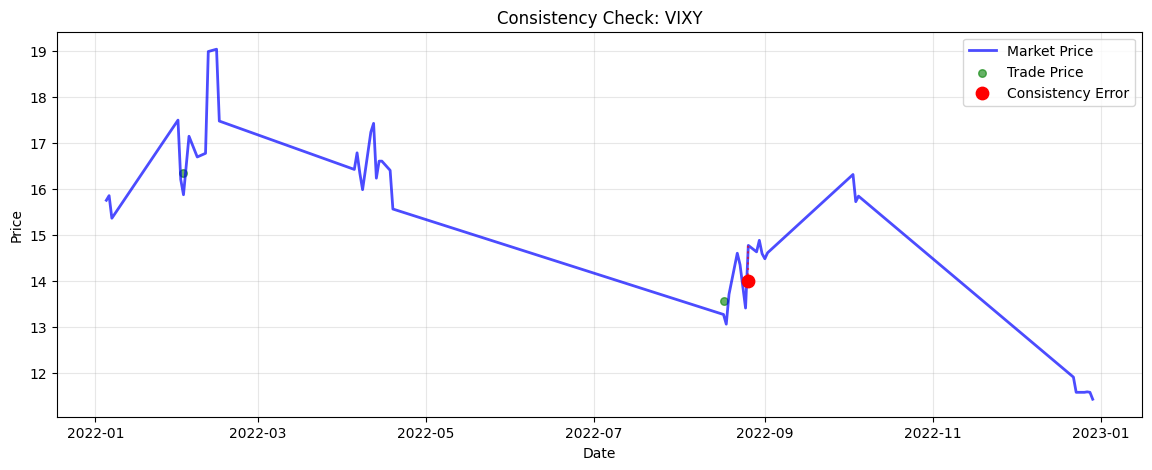

Visualizing consistency errors for: CELH (Count: 1)


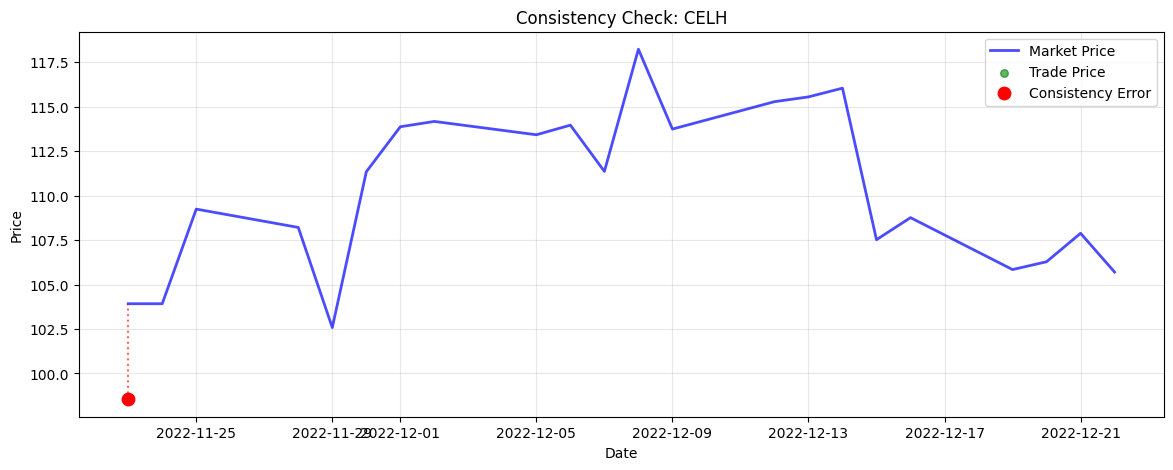

Visualizing consistency errors for: RIVN (Count: 1)


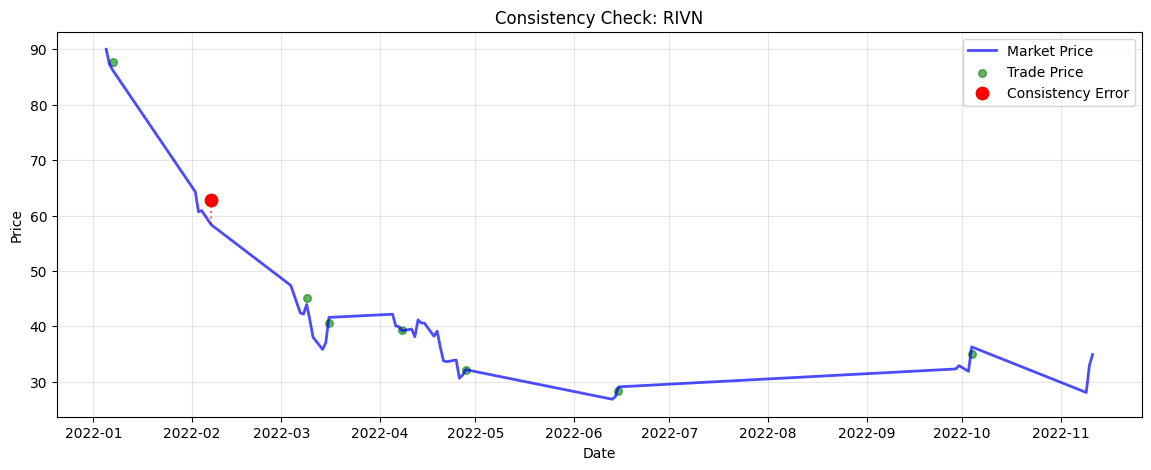

Visualizing consistency errors for: KAP (Count: 1)


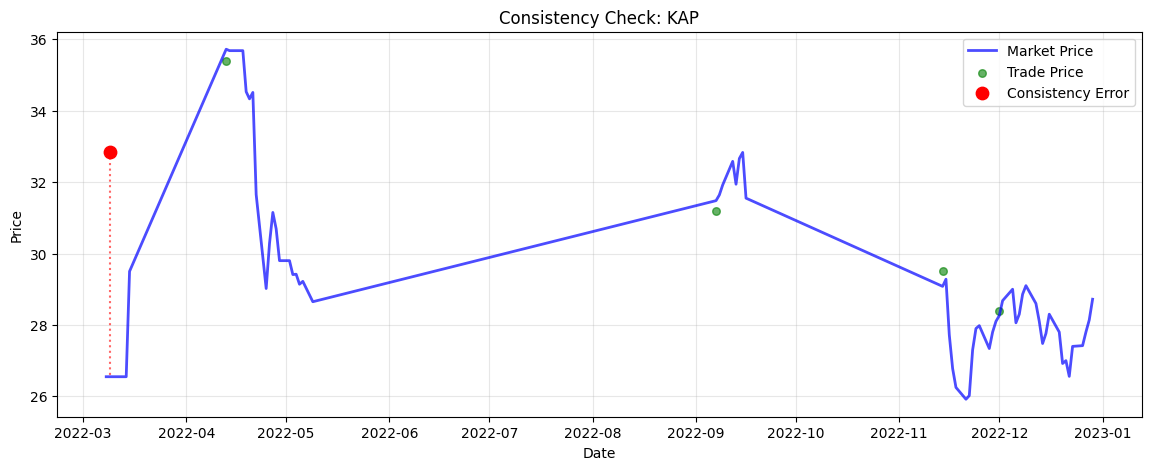

Visualizing consistency errors for: SLR (Count: 1)


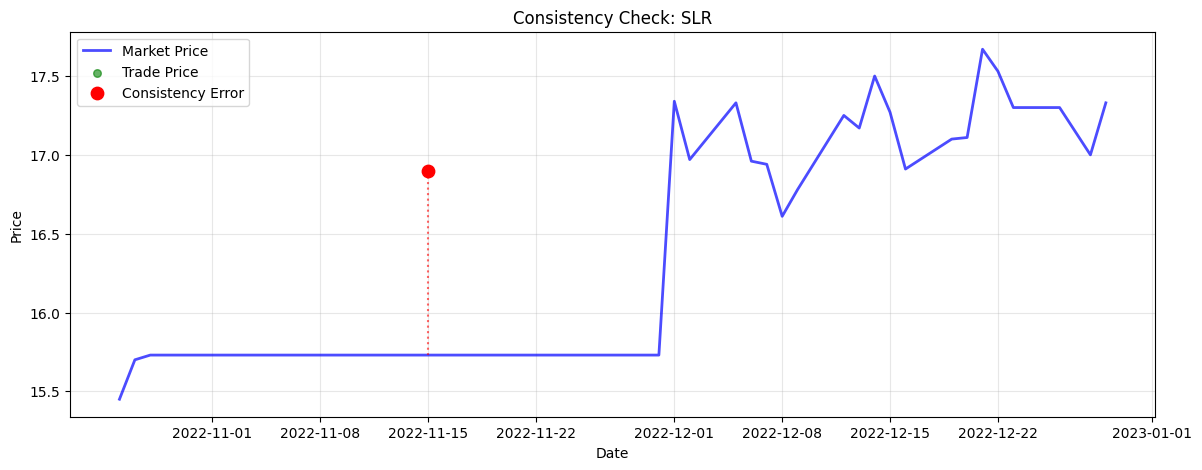

Visualizing consistency errors for: AMC (Count: 1)


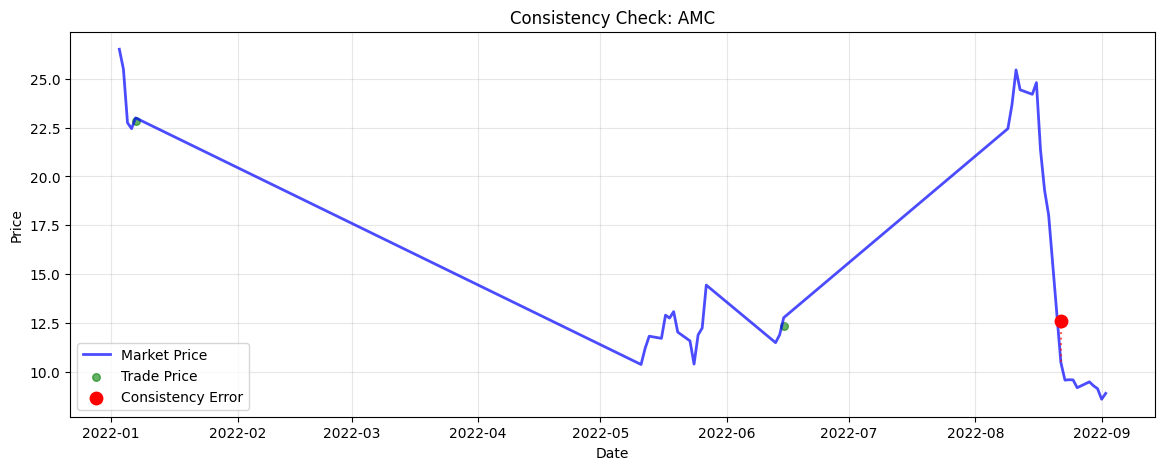

Visualizing consistency errors for: BNTX (Count: 2)


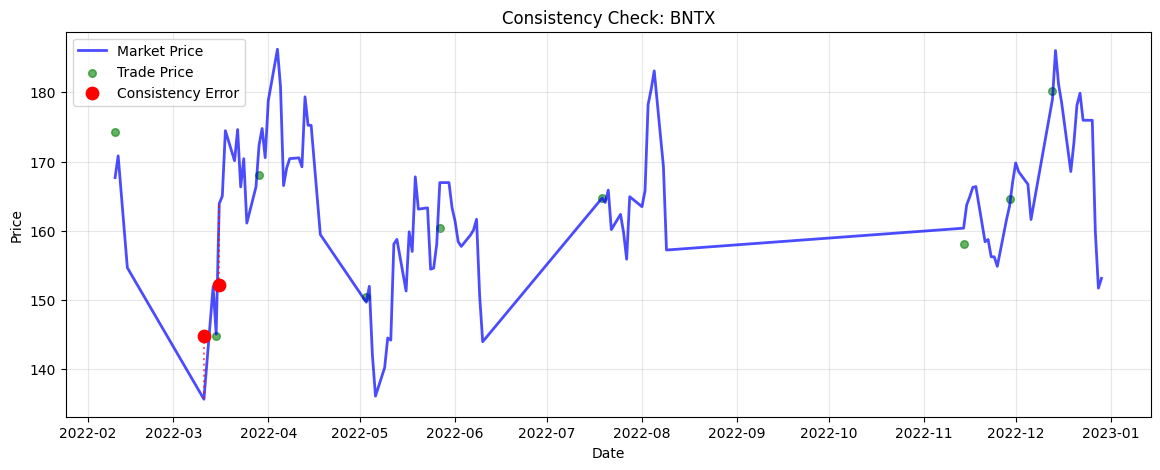

Visualizing consistency errors for: SQ (Count: 1)


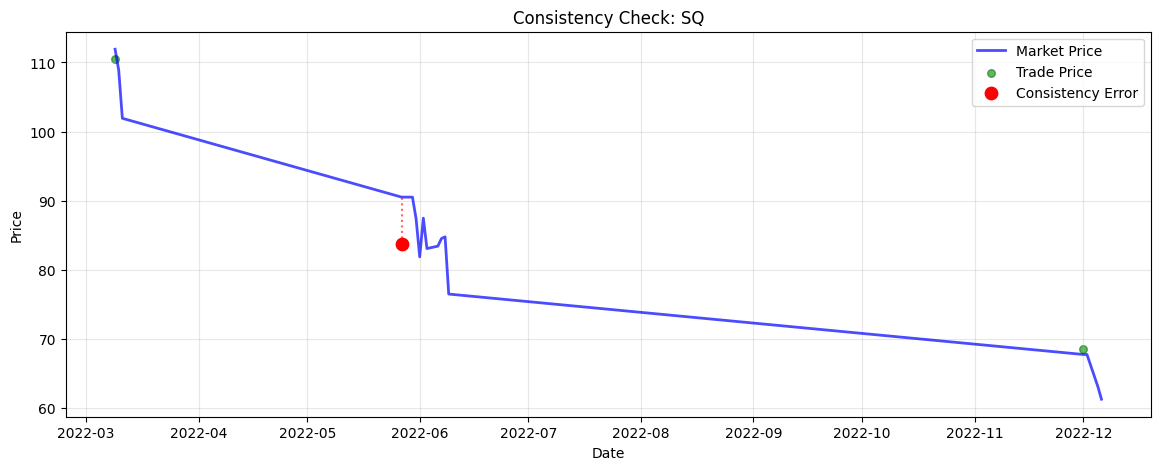

Visualizing consistency errors for: MSTR (Count: 1)


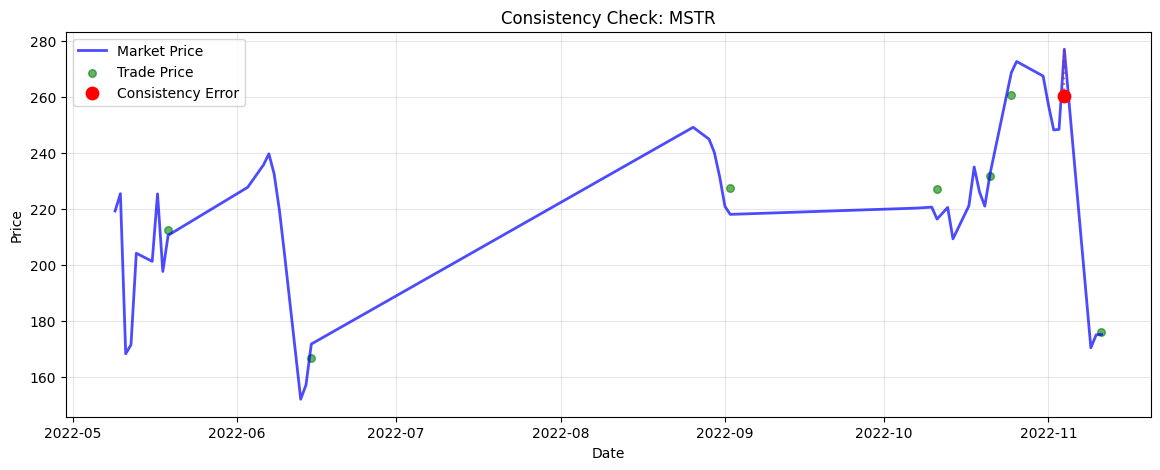

Visualizing consistency errors for: GME (Count: 1)


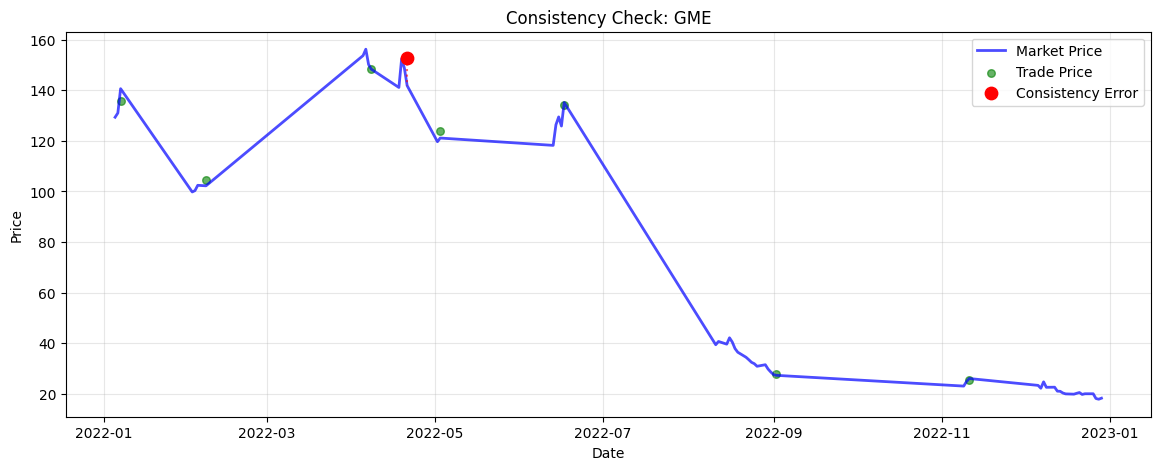

Visualizing consistency errors for: ARKK (Count: 4)


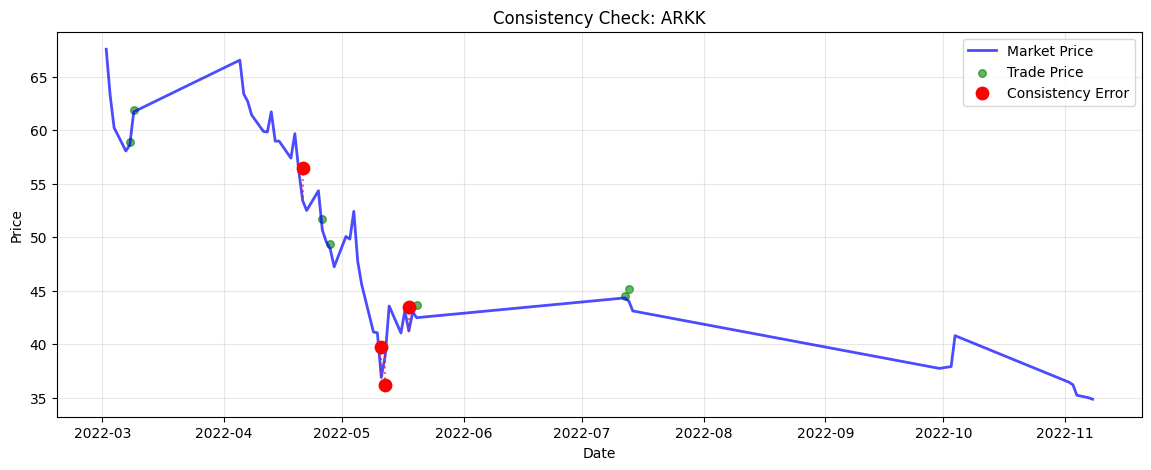

Visualizing consistency errors for: FUTU (Count: 1)


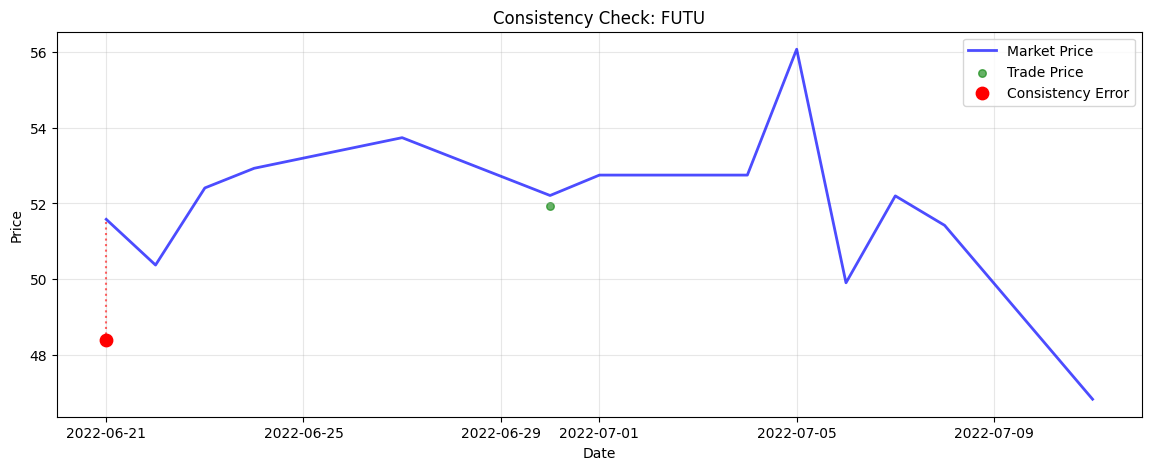

Visualizing consistency errors for: GRE1 (Count: 1)


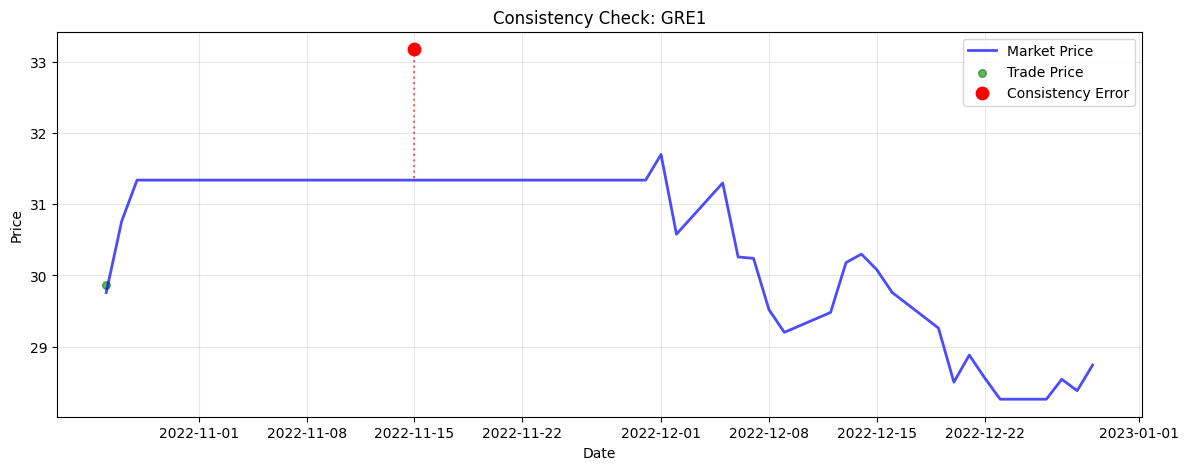

Visualizing consistency errors for: CVNA (Count: 2)


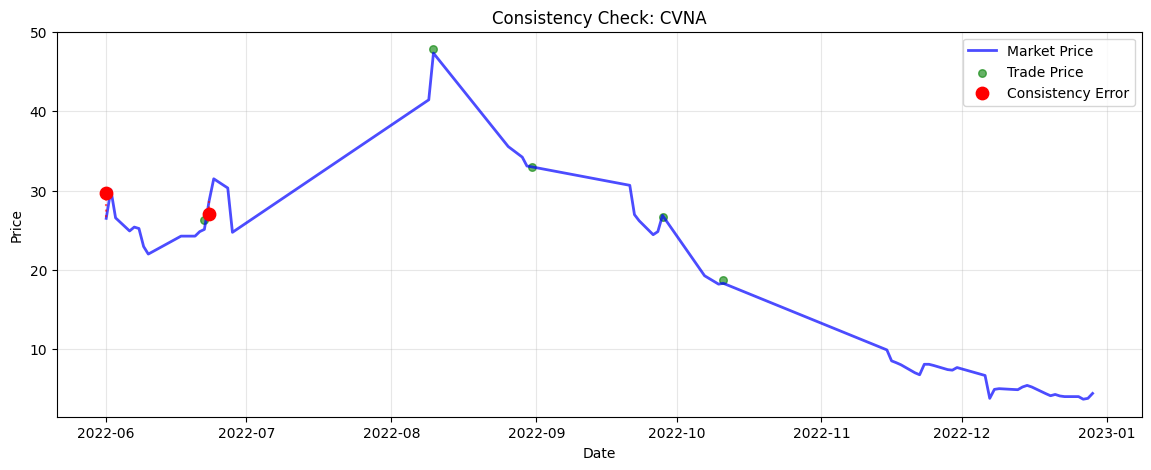

In [6]:
def visualize_ticker_consistency(ticker, error_list, positions_df):
    # Filter errors for this ticker
    ticker_errors = [e for e in error_list if e.ticker == ticker]
    if not ticker_errors:
        return

    print(f"Visualizing consistency errors for: {ticker} (Count: {len(ticker_errors)})")
    
    # Prepare data
    ticker_df = positions_df[positions_df['P_Ticker'] == ticker].copy()
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])  # type: ignore
    ticker_df = ticker_df.sort_values('Date')
    
    ticker_df['Price'] = pd.to_numeric(ticker_df['Price'], errors='coerce')
    ticker_df['Trade Price'] = pd.to_numeric(ticker_df['Trade Price'], errors='coerce')
    ticker_df['Traded Today'] = pd.to_numeric(ticker_df['Traded Today'], errors='coerce').fillna(0)
    
    plt.figure(figsize=(14, 5))
    
    plt.plot(ticker_df['Date'], ticker_df['Price'], label='Market Price', color='blue', linewidth=2, alpha=0.7)
    
    # Plot trades
    trades_only = ticker_df[ticker_df['Traded Today'].abs() > 0]
    plt.scatter(trades_only['Date'], trades_only['Trade Price'], label='Trade Price', color='green', marker='o', s=30, alpha=0.6)
    
    # Highlight errors
    error_dates = [e.date for e in ticker_errors]
    error_points = ticker_df[ticker_df['Date'].isin(error_dates)]
    
    if not error_points.empty:
        plt.scatter(error_points['Date'], error_points['Trade Price'], color='red', s=80, zorder=5, label='Consistency Error')
        
        # Draw vertical lines connecting Trade Price to Market Price
        for _, row in error_points.iterrows():
            plt.plot([row['Date'], row['Date']], [row['Trade Price'], row['Price']], 
                     color='red', linestyle=':', linewidth=1.5, alpha=0.6)

    plt.title(f"Consistency Check: {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize all found errors (since we only have a few)
if errors:
    # Get unique tickers with errors
    error_tickers = list(set(e.ticker for e in errors))
    
    print(f"Visualizing {len(error_tickers)} tickers with consistency errors.")
    for ticker in error_tickers:
        visualize_ticker_consistency(ticker, errors, positions)
else:
    print("No errors found.")